In [2]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
from tqdm import tqdm
from PIL import Image

from models.clip_model import CLIPModel
from models.llava_classifier import LLaVAClassifier
from dataset.cifar10 import CIFAR10Dataset
from dataset.cifar20 import CIFAR20Dataset

/nfs/home/maitanha/cll_vlm/cll_vlm/vlm/CLIP


/home/maitanha/cll_vlm/venv_cll_llava/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# save_csv_path = "clip_similarity_cifar10.csv"

batch_size = 256         
num_workers = 4              # số luồng đọc dữ liệu

dataset = CIFAR20Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar20",
    train=True
)
label_names = dataset.classes  # ['airplane', 'automobile', 'bird', ...]
print("Labels:", label_names)
print(f"Total samples: {len(dataset)}")

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

Labels: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Total samples: 50000


In [ ]:
clip_model = CLIPModel(model_name="ViT-L/14@336px", device=device)
text_features = clip_model.encode_text(label_names)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [12]:
records = []

for batch_id, (batch_imgs, batch_targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
    start = batch_id * dataloader.batch_size
    end = start + len(batch_imgs)
    batch_indices = list(range(start, end))  # giả lập index, nếu shuffle=False
    
    img_feats = clip_model.encode_image(batch_imgs)
    img_feats /= img_feats.norm(dim=-1, keepdim=True)

    sims = (img_feats @ text_features.T).cpu().tolist()

    for i in range(len(batch_imgs)):
        records.append({
            "index": batch_indices[i],
            "true_label_idx": int(batch_targets[i]),
            "true_label": label_names[int(batch_targets[i])],
            "similarities": sims[i],
        })

df = pd.DataFrame(records)
df.to_csv(save_csv_path, index=False)
print(f"Saved full CLIP similarity results to {save_csv_path}")

100%|██████████| 196/196 [05:55<00:00,  1.81s/it]


Saved full CLIP similarity results to clip_similarity_cifar10.csv


In [1]:
import pandas as pd
import ast
import torch

# ====== Load file ======
df = pd.read_csv("clip_similarity_cifar10.csv")
df["similarities"] = df["similarities"].apply(ast.literal_eval)

# ====== CIFAR-10 label order ======
classes = ["airplane", "automobile", "bird", "cat", "deer",
           "dog", "frog", "horse", "ship", "truck"]

# ====== Statistics counters ======
total = len(df)
top1_correct = 0
top3_correct = 0
top5_correct = 0

for _, row in df.iterrows():
    sims = torch.tensor(row["similarities"])
    true_label = row["true_label"]
    true_idx = row["true_label_idx"]

    # Sort indices descending by similarity
    sorted_idx = torch.argsort(sims, descending=True).tolist()
    top1 = [classes[sorted_idx[0]]]
    top3 = [classes[i] for i in sorted_idx[:3]]
    top5 = [classes[i] for i in sorted_idx[:5]]

    # Check correctness
    if classes[true_idx] in top1:
        top1_correct += 1
    if classes[true_idx] in top3:
        top3_correct += 1
    if classes[true_idx] in top5:
        top5_correct += 1

# ====== Compute accuracy ======
acc_top1 = top1_correct / total * 100
acc_top3 = top3_correct / total * 100
acc_top5 = top5_correct / total * 100

print("📊 CLIP Top-k Accuracy Results")
print(f"Total samples: {total}")
print(f"Top-1 accuracy: {acc_top1:.2f}%")
print(f"Top-3 accuracy: {acc_top3:.2f}%")
print(f"Top-5 accuracy: {acc_top5:.2f}%")

# ====== Optional: save to file ======
with open("clip_topk_accuracy.txt", "w") as f:
    f.write("CLIP Top-k Accuracy Results\n")
    f.write(f"Total samples: {total}\n")
    f.write(f"Top-1 accuracy: {acc_top1:.2f}%\n")
    f.write(f"Top-3 accuracy: {acc_top3:.2f}%\n")
    f.write(f"Top-5 accuracy: {acc_top5:.2f}%\n")

print("✅ Saved results to clip_topk_accuracy.txt")


📊 CLIP Top-k Accuracy Results
Total samples: 50000
Top-1 accuracy: 91.88%
Top-3 accuracy: 98.59%
Top-5 accuracy: 99.46%
✅ Saved results to clip_topk_accuracy.txt


In [5]:
# ====== Counter ======
total = len(df)
match_2to5 = 0

for _, row in df.iterrows():
    sims = torch.tensor(row["similarities"])
    true_idx = int(row["true_label_idx"])
    true_label = classes[true_idx]

    # sort descending
    sorted_idx = torch.argsort(sims, descending=True).tolist()
    top2to5 = [classes[i] for i in sorted_idx[1:5]]  # skip top1, take 2–5

    if true_label in top2to5:
        match_2to5 += 1

# ====== Compute percentage ======
percent = match_2to5 / total * 100

print("CLIP Top-2~5 Match Check")
print(f"Total samples: {total}")
print(f"Samples where true label appears in top-2~5: {match_2to5} ({percent:.2f}%)")

CLIP Top-2~5 Match Check
Total samples: 50000
Samples where true label appears in top-2~5: 3792 (7.58%)


# Analyze

In [30]:
import pandas as pd
import ast
import torch

# Load files
clip_df = pd.read_csv("clip_similarity_cifar20.csv")
llava_df = pd.read_csv("cifar20_bottom_least.csv")

# Parse list columns
clip_df["similarities"] = clip_df["similarities"].apply(ast.literal_eval)
llava_df["candidate_labels"] = llava_df["candidate_labels"].apply(ast.literal_eval)

print("CLIP:", len(clip_df), "samples")
print("LLaVA:", len(llava_df), "samples")

CLIP: 50000 samples
LLaVA: 50000 samples


['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


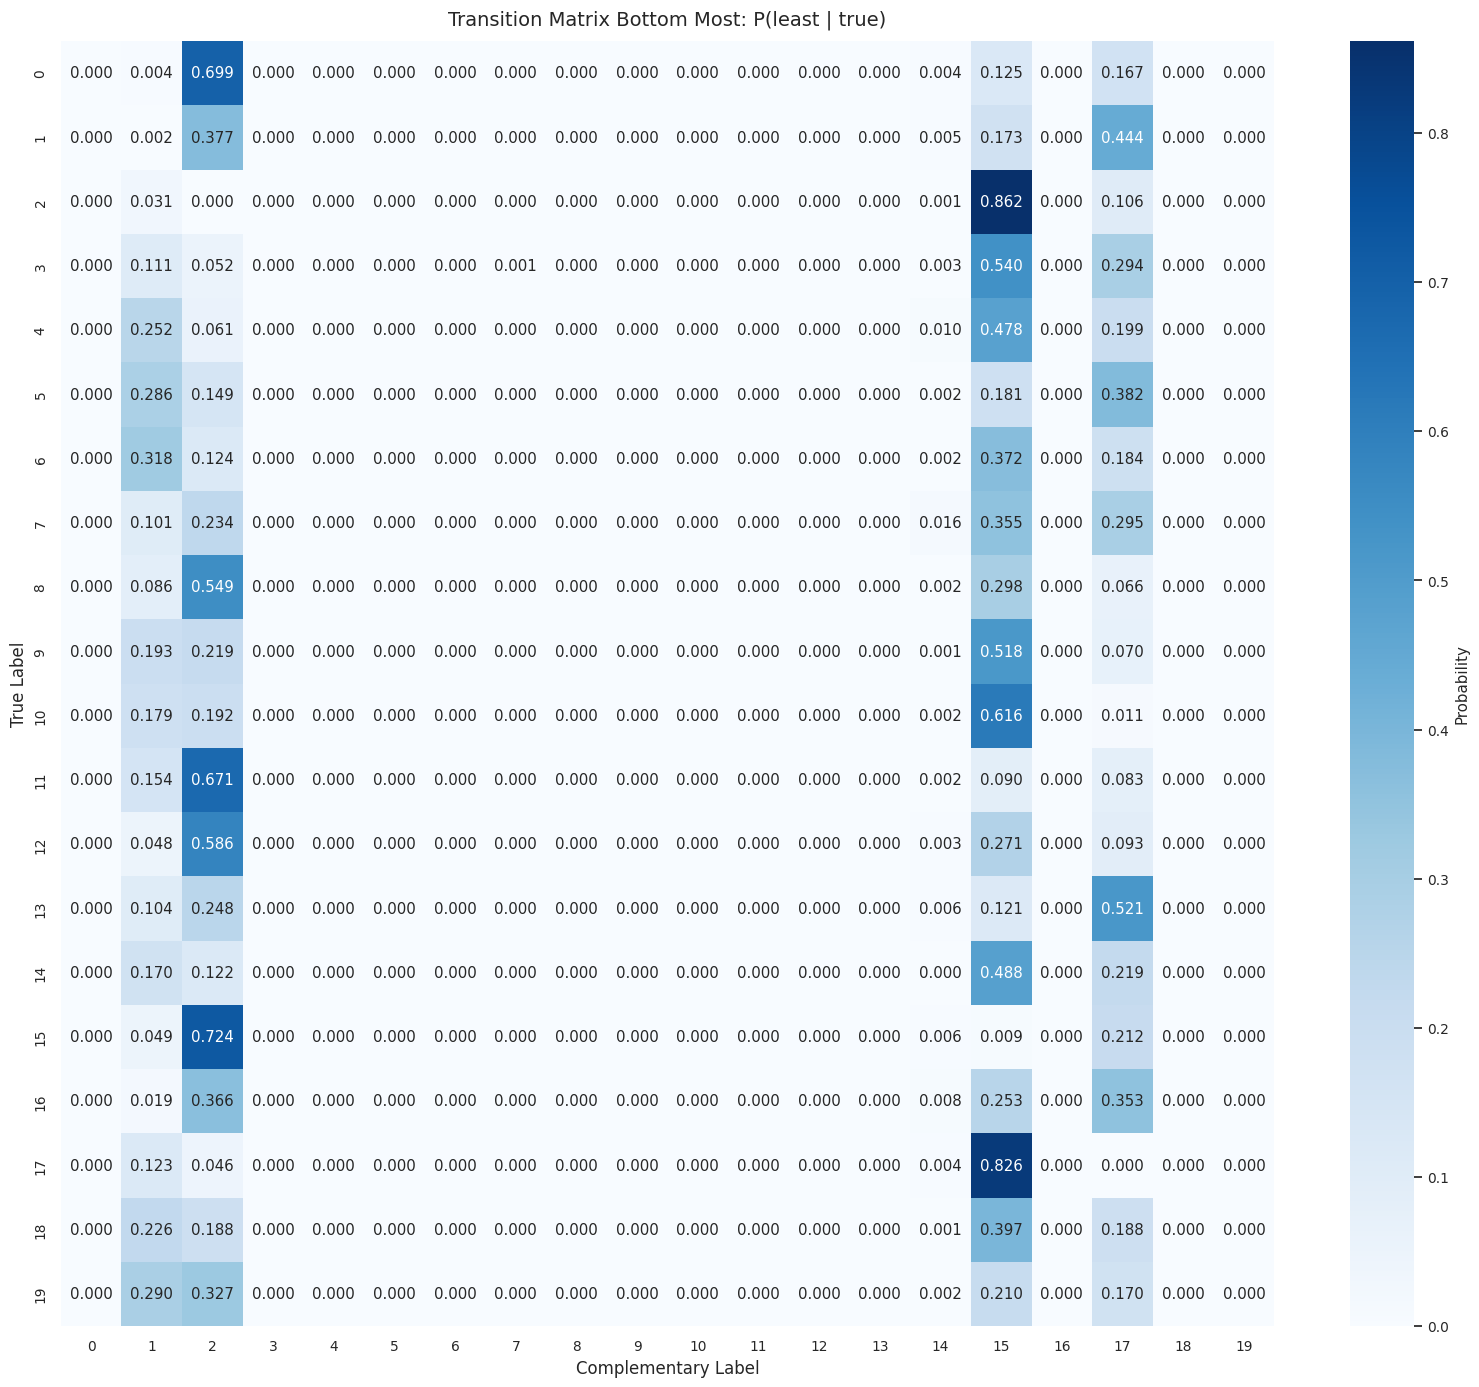

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# ====== Define class order ======
# CIFAR-10 official label order
classes = dataset.classes  # ['airplane', 'automobile', 'bird', ...]
n_classes = len(classes)
print(classes)

# ====== Create transition count matrix ======
matrix = pd.DataFrame(0, index=classes, columns=classes, dtype=float)

# Count transitions: true_label → complementary_label
for _, row in llava_df.iterrows():
    true_label = row["true_label"]
    comp_label = row["complementary_label"]
    if true_label in classes and comp_label in classes:
        matrix.loc[true_label, comp_label] += 1

# ====== Normalize by row to get probabilities ======
transition_matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)
transition_matrix.index = range(n_classes)
transition_matrix.columns = range(n_classes)

# ====== Plot ======
plt.figure(figsize=(16, 14))
ax = sns.heatmap(
    transition_matrix,
    annot=True,
    cmap="Blues",
    fmt=".3f",
    cbar_kws={'label': 'Probability'},
)
plt.title("Transition Matrix Bottom Most: P(least | true)", fontsize=14, pad=12)
plt.xlabel("Complementary Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

with open("cifar20_bottom_least_transition_matrix.txt", "w", encoding="utf-8") as f:
    f.write(transition_matrix.to_string(float_format=lambda x: f"{x:.3f}"))

### Least transition matrix

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


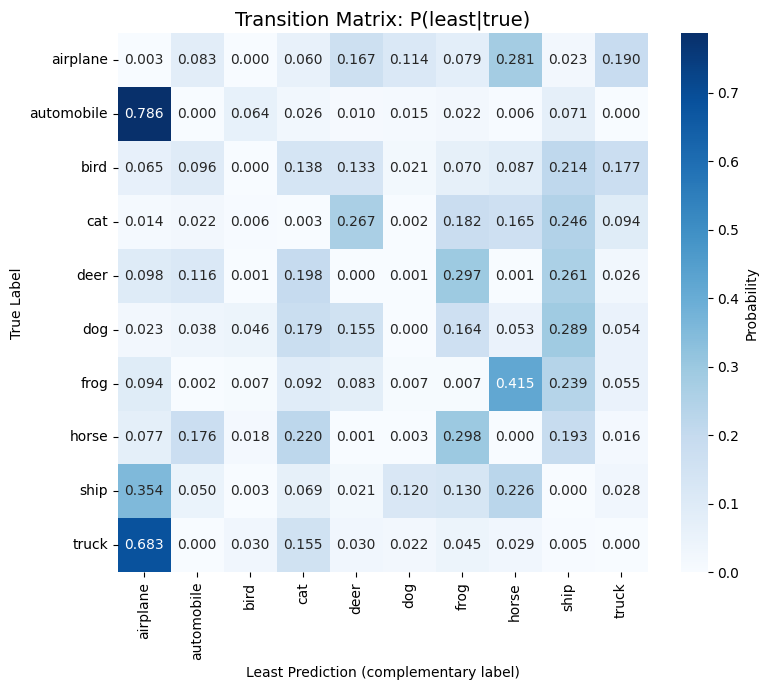

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ====== Load CSV ======
df = pd.read_csv("clip_llava_least_result.csv")
df.head()

# ====== Define class order ======
# CIFAR-10 official label order
classes = dataset.classes  # ['airplane', 'automobile', 'bird', ...]
print(classes)

# ====== Create transition count matrix ======
matrix = pd.DataFrame(0, index=classes, columns=classes, dtype=float)

# Count transitions: true_label → complementary_label
for _, row in df.iterrows():
    true_label = row["true_label"]
    comp_label = row["complementary_label"]
    if true_label in classes and comp_label in classes:
        matrix.loc[true_label, comp_label] += 1

# ====== Normalize by row to get probabilities ======
transition_matrix = matrix.div(matrix.sum(axis=1), axis=0).fillna(0)

# ====== Plot ======
plt.figure(figsize=(8, 7))
sns.heatmap(
    transition_matrix, annot=True, cmap="Blues",
    fmt=".3f", cbar_kws={'label': 'Probability'}
)
plt.title("Transition Matrix: P(least|true)", fontsize=14)
plt.xlabel("Least Prediction (complementary label)")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

with open("least_transition_matrix.txt", "w", encoding="utf-8") as f:
    f.write("Transition Matrix: P(least | true)\n\n")
    f.write(transition_matrix.to_string(float_format=lambda x: f"{x:.3f}"))

# CIFAR 20

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
save_csv_path = "clip_similarity_cifar20.csv"

batch_size = 256         
num_workers = 4              # số luồng đọc dữ liệu

dataset = CIFAR20Dataset(
    root="/home/maitanha/cll_vlm/cll_vlm/data/cifar20",
    train=True
)
label_names = dataset.classes  # ['airplane', 'automobile', 'bird', ...]
print("Labels:", label_names)
print(f"Total samples: {len(dataset)}")

def collate_fn(batch):
    imgs, targets = zip(*batch)
    return list(imgs), torch.tensor(targets)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

Labels: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']
Total samples: 50000


In [5]:
label_names

['aquatic_mammals',
 'fish',
 'flowers',
 'food_containers',
 'fruit_and_vegetables',
 'household_electrical_devices',
 'household_furniture',
 'insects',
 'large_carnivores',
 'large_man-made_outdoor_things',
 'large_natural_outdoor_scenes',
 'large_omnivores_and_herbivores',
 'medium_mammals',
 'non-insect_invertebrates',
 'people',
 'reptiles',
 'small_mammals',
 'trees',
 'vehicles_1',
 'vehicles_2']

In [8]:
processed_labels = []
for label in label_names:
    # nếu bắt đầu bằng 'vehicles_', chuyển thành 'vehicles'
    if label.startswith('vehicles_'):
        processed_labels.append('vehicles')
    else:
        # thay dấu _ bằng khoảng trắng
        processed_labels.append(label.replace('_', ' '))

print(processed_labels)

text = [f"A photo of a {processed_label}" for processed_label in processed_labels]

['aquatic mammals', 'fish', 'flowers', 'food containers', 'fruit and vegetables', 'household electrical devices', 'household furniture', 'insects', 'large carnivores', 'large man-made outdoor things', 'large natural outdoor scenes', 'large omnivores and herbivores', 'medium mammals', 'non-insect invertebrates', 'people', 'reptiles', 'small mammals', 'trees', 'vehicles', 'vehicles']


In [9]:
clip_model = CLIPModel(model_name="ViT-L/14@336px", device=device)
text_features = clip_model.encode_text(text)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [10]:
records = []

for batch_id, (batch_imgs, batch_targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
    start = batch_id * dataloader.batch_size
    end = start + len(batch_imgs)
    batch_indices = list(range(start, end))  # giả lập index, nếu shuffle=False
    
    img_feats = clip_model.encode_image(batch_imgs)
    img_feats /= img_feats.norm(dim=-1, keepdim=True)

    sims = (img_feats @ text_features.T).cpu().tolist()

    for i in range(len(batch_imgs)):
        records.append({
            "index": batch_indices[i],
            "true_label_idx": int(batch_targets[i]),
            "true_label": label_names[int(batch_targets[i])],
            "similarities": sims[i],
        })

df = pd.DataFrame(records)
df.to_csv(save_csv_path, index=False)
print(f"Saved full CLIP similarity results to {save_csv_path}")

100%|██████████| 196/196 [06:02<00:00,  1.85s/it]


Saved full CLIP similarity results to clip_similarity_cifar20.csv


In [11]:
df.head

<bound method NDFrame.head of        index  true_label_idx                      true_label  \
0          0              11  large_omnivores_and_herbivores   
1          1              15                        reptiles   
2          2               4            fruit_and_vegetables   
3          3              14                          people   
4          4               1                            fish   
...      ...             ...                             ...   
49995  49995              16                   small_mammals   
49996  49996               7                         insects   
49997  49997               8                large_carnivores   
49998  49998               7                         insects   
49999  49999               1                            fish   

                                            similarities  
0      [0.18310546875, 0.1553955078125, 0.14245605468...  
1      [0.1937255859375, 0.139404296875, 0.1224975585...  
2      [0.185302734375, 